<a href="https://colab.research.google.com/github/DrigoDomingos/onfarm/blob/master/onfarm_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upload the files

In [16]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer   

# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'} # each region has its XGBoost container
my_region = boto3.session.Session().region_name # set the region of the instance
print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + containers[my_region] + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-east-2 region. You will use the 825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


In [17]:
bucket_name = 'onfarm-deep-learning-azul-claro' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
s3 = boto3.resource('s3')

In [19]:
#!/usr/bin/python
import boto3
s3=boto3.client('s3')
list=s3.list_objects(Bucket='onfarm-deep-learning-azul-claro')['Contents']
for s3_key in list:
    s3_object = s3_key['Key']
    if not s3_object.endswith("/"):
        s3.download_file('onfarm-deep-learning-azul-claro', s3_object, s3_object)
    else:
        import os
        if not os.path.exists(s3_object):
            os.makedirs(s3_object)

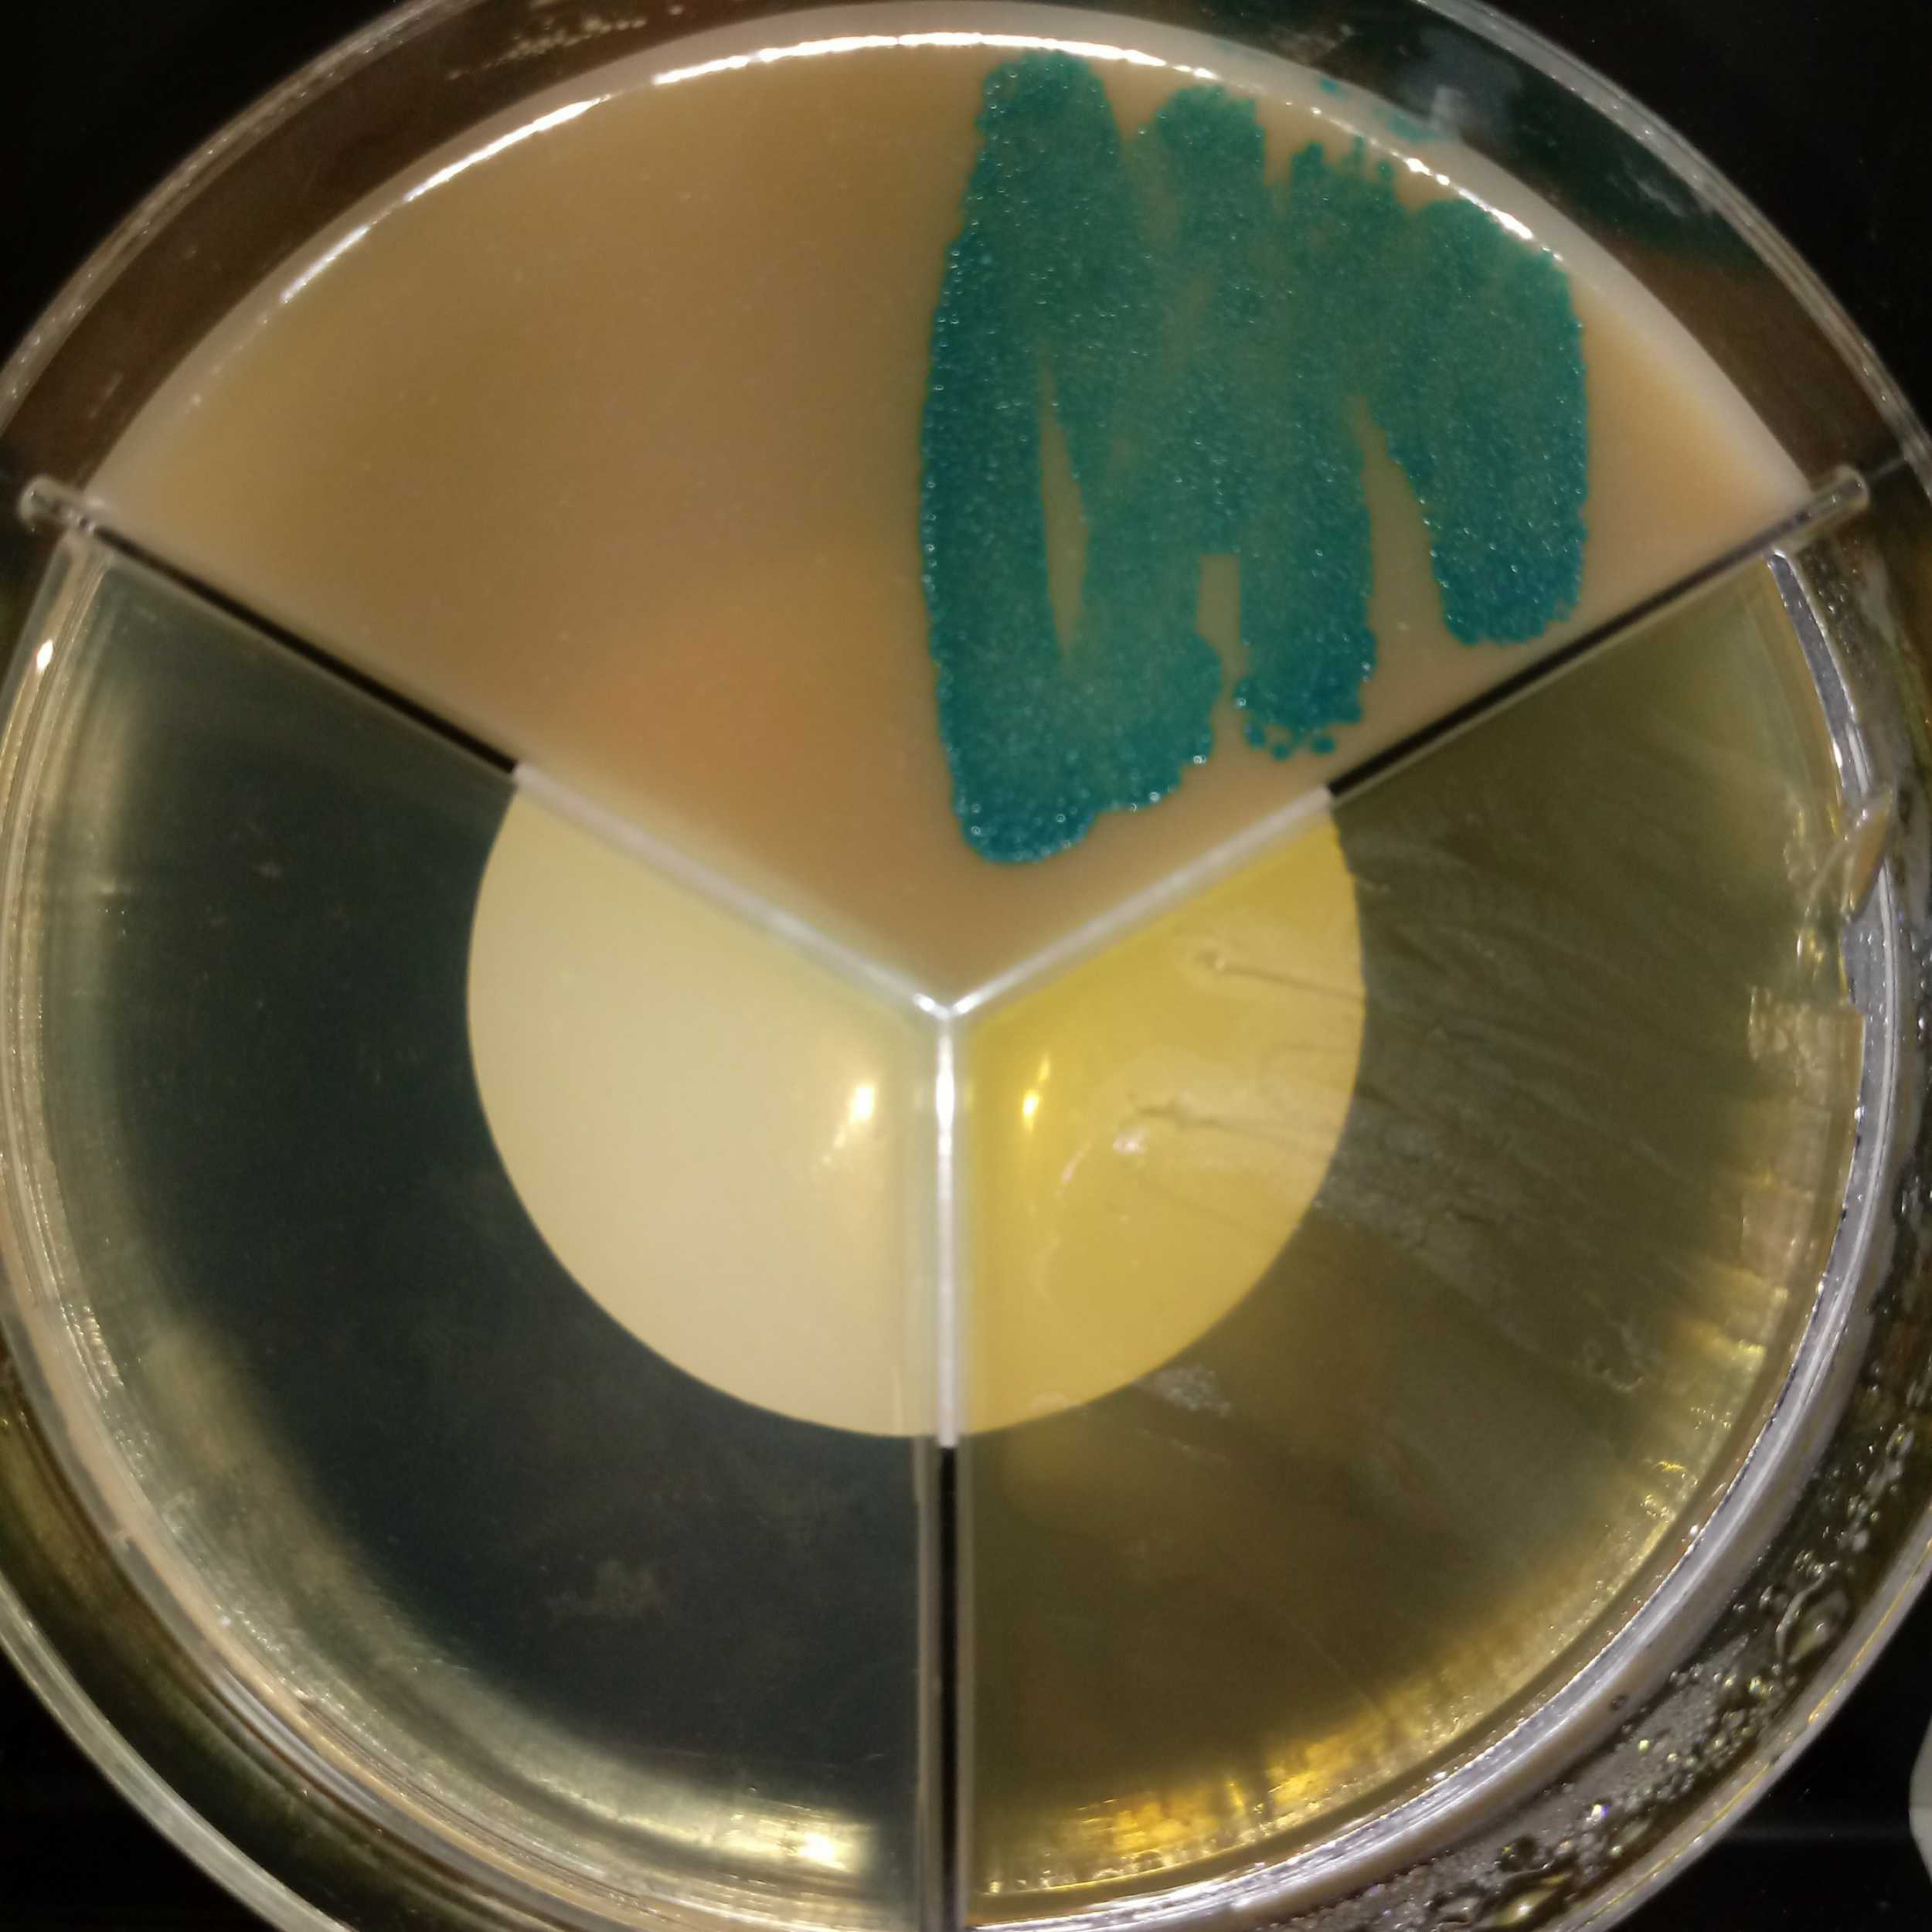

In [3]:
import s3fs
from PIL import Image
fs = s3fs.S3FileSystem()

# To List 5 files in your accessible bucket
fs.ls('s3://onfarm-deep-learning-azul-claro/')[:5]

# open it directly
with fs.open(f's3://onfarm-deep-learning-azul-claro/0.jpg') as f:
    display(Image.open(f))

In [ ]:
#!unzip 001.zip

In [20]:
pwd

'/home/ec2-user/SageMaker/onfarm'

In [ ]:
#mv /content/001/model_frcnn.hdf5 /content/

pwd

# Convert XML to CSV

In [23]:
import os, sys, random
import xml.etree.ElementTree as ET
from glob import glob
import pandas as pd
from shutil import copyfile


def convert_xml2csv(path):
  annotations = glob(path)
  df = []
  cnt = 0
  for file in annotations:
      #filename = file.split('/')[-1].split('.')[0] + '.jpg'
      #filename = str(cnt) + '.jpg'
      filename = file.split('\\')[-1]
      filename =filename.split('.')[0] + '.jpg'
      row = []
      parsedXML = ET.parse(file)
      for node in parsedXML.getroot().iter('object'):
          blood_cells = node.find('name').text
          xmin = int(node.find('bndbox/xmin').text)
          xmax = int(node.find('bndbox/xmax').text)
          ymin = int(node.find('bndbox/ymin').text)
          ymax = int(node.find('bndbox/ymax').text)

          row = [filename, blood_cells, xmin, xmax, ymin, ymax]
          df.append(row)
          cnt += 1

  data = pd.DataFrame(df, columns=['filename', 'cell_type', 'xmin', 'xmax', 'ymin', 'ymax'])

  data[['filename', 'cell_type', 'xmin', 'xmax', 'ymin', 'ymax']].to_csv('images.csv', index=False)


#Azul claro
convert_xml2csv('/home/ec2-user/SageMaker/onfarm/img_train/*.xml')


# Install libraries

In [24]:
!head images.csv

filename,cell_type,xmin,xmax,ymin,ymax
/home/ec2-user/SageMaker/onfarm/img_train/111.jpg,azul_claro,601,633,989,1049
/home/ec2-user/SageMaker/onfarm/img_train/111.jpg,azul_claro,661,693,689,728
/home/ec2-user/SageMaker/onfarm/img_train/111.jpg,azul_claro,524,552,949,989
/home/ec2-user/SageMaker/onfarm/img_train/111.jpg,azul_claro,486,524,985,1015
/home/ec2-user/SageMaker/onfarm/img_train/111.jpg,azul_claro,569,635,755,802
/home/ec2-user/SageMaker/onfarm/img_train/111.jpg,azul_claro,1065,1116,568,619
/home/ec2-user/SageMaker/onfarm/img_train/111.jpg,azul_claro,1067,1112,636,685
/home/ec2-user/SageMaker/onfarm/img_train/111.jpg,azul_claro,941,980,500,553
/home/ec2-user/SageMaker/onfarm/img_train/111.jpg,azul_claro,1052,1090,434,479


In [25]:
# importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches

In [26]:
# read the csv file using read_csv function of pandas
train = pd.read_csv('images.csv')
train.head()

,filename,cell_type,xmin,xmax,ymin,ymax
0,/home/ec2-user/SageMaker/onfarm/img_train/111.jpg,azul_claro,601,633,989,1049
1,/home/ec2-user/SageMaker/onfarm/img_train/111.jpg,azul_claro,661,693,689,728
2,/home/ec2-user/SageMaker/onfarm/img_train/111.jpg,azul_claro,524,552,949,989
3,/home/ec2-user/SageMaker/onfarm/img_train/111.jpg,azul_claro,486,524,985,1015
4,/home/ec2-user/SageMaker/onfarm/img_train/111.jpg,azul_claro,569,635,755,802


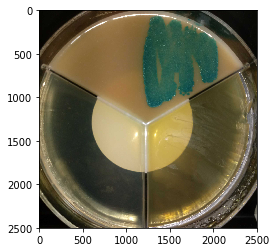

In [13]:
import boto3
from io import BytesIO
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

resource = boto3.resource('s3', region_name='us-east-2')
bucket = resource.Bucket('onfarm-deep-learning-azul-claro')

image_object = bucket.Object('0.jpg')
image = mpimg.imread(BytesIO(image_object.get()['Body'].read()), 'jpg')

plt.figure(0)
plt.imshow(image)

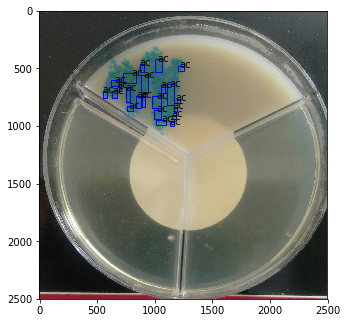

In [41]:
fig = plt.figure()



#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
image = plt.imread('/home/ec2-user/SageMaker/onfarm/img_train/115.jpg')
plt.imshow(image)



# iterating over the image for different objects
for _,row in train[train.filename == "/home/ec2-user/SageMaker/onfarm/img_train/115.jpg"].iterrows():
    xmin = row.xmin
    xmax = row.xmax
    ymin = row.ymin
    ymax = row.ymax
    
    width = xmax - xmin
    height = ymax - ymin
    
    # assign different color to different classes of objects
    if row.cell_type == 'azul_claro':
        edgecolor = 'b'
        ax.annotate('ac', xy=(xmax-40,ymin+20))
 #   elif row.cell_type == 'WBC':
 #       edgecolor = 'b'
 #       ax.annotate('WBC', xy=(xmax-40,ymin+20))
 #   elif row.cell_type == 'Platelets':
 #       edgecolor = 'g'
 #       ax.annotate('Platelets', xy=(xmax-40,ymin+20))
        
    # add bounding boxes to the image
    rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)

In [54]:
data = pd.DataFrame()
data['format'] = train['filename']

# as the images are in train_images folder, add train_images before the image name
for i in range(data.shape[0]):
    data['format'][i] = data['format'][i]

# add xmin, ymin, xmax, ymax and class as per the format required
for i in range(data.shape[0]):
    data['format'][i] = data['format'][i] + ',' + str(train['xmin'][i]) + ',' + str(train['ymin'][i]) + ',' + str(train['xmax'][i]) + ',' + str(train['ymax'][i]) + ',' + train['cell_type'][i]

data.to_csv('annotate.txt', header=None, index=None, sep=' ')

In [30]:
!head annotate.txt

/home/ec2-user/SageMaker/onfarm/img_train/111.jpg,601,989,633,1049,azul_claro
/home/ec2-user/SageMaker/onfarm/img_train/111.jpg,661,689,693,728,azul_claro
/home/ec2-user/SageMaker/onfarm/img_train/111.jpg,524,949,552,989,azul_claro
/home/ec2-user/SageMaker/onfarm/img_train/111.jpg,486,985,524,1015,azul_claro
/home/ec2-user/SageMaker/onfarm/img_train/111.jpg,569,755,635,802,azul_claro
/home/ec2-user/SageMaker/onfarm/img_train/111.jpg,1065,568,1116,619,azul_claro
/home/ec2-user/SageMaker/onfarm/img_train/111.jpg,1067,636,1112,685,azul_claro
/home/ec2-user/SageMaker/onfarm/img_train/111.jpg,941,500,980,553,azul_claro
/home/ec2-user/SageMaker/onfarm/img_train/111.jpg,1052,434,1090,479,azul_claro
/home/ec2-user/SageMaker/onfarm/img_train/111.jpg,888,426,937,477,azul_claro


In [32]:
!pip install -r requirements.txt

     |████████████████████████████████| 307kB 3.1MB/s eta 0:00:01
     |████████████████████████████████| 28.2MB 8.0MB/s eta 0:00:01
     |████████████████████████████████| 49.1MB 471kB/s  eta 0:00:01    |█▋                              | 2.5MB 30.8MB/s eta 0:00:02
     |████████████████████████████████| 51kB 9.8MB/s  eta 0:00:01
     |████████████████████████████████| 3.1MB 23.5MB/s eta 0:00:01
     |████████████████████████████████| 890kB 23.2MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1321 sha256=70199c5a671cf22407b0d56e6c35770850e0e4efc9d98a4c4ee6bf5aa210f5e2
  Stored in directory: /home/ec2-user/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
  Created wheel for html5lib: filename=html5lib-0.9999999-cp36-none-any.whl size=106397 sha256=755bebd86ea933aa9a17642876667b4c489dd5e1b5f9170eff0f496616b5d525
  Stored in directory: /home/ec2-user/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898e

In [52]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

In [55]:
!python3 train_frcnn.py -o simple -p annotate.txt --input_weight_path /home/ec2-user/SageMaker/onfarm/model_trained/model_frcnn.hdf5

Using TensorFlow backend.
Parsing annotation files
Training images per class:
{'azul_claro': 3900, 'bg': 0}
Num classes (including bg) = 2
Config has been written to /home/ec2-user/SageMaker/onfarm/model_trained/config.pickle, and can be loaded when testing to ensure correct results
Num train samples 91
Num val samples 16
loading weights from /home/ec2-user/SageMaker/onfarm/model_trained/model_frcnn.hdf5
2020-03-04 09:55:09.403984: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
Starting training
Epoch 1/10
 43/500 [=>............................] - ETA: 14:23:30 - rpn_cls: 8.0088 - rpn_regr: 1.4911 - detector_cls: 0.4239 - detector_regr: 0.0000e+00^C


-rw-r--r-- 1 root root 113893120 Feb 28 17:34 model_frcnn.hdf5


MessageError: ignored

In [ ]:
!python3 test_frcnn.py -p /content/test/